O intuito deste projeto é a construção de um modelo de classificação utilizando redes neurais, para classificação de um dataset de animais em duas etapas. Primeiramente será trabalhado de forma binária (classificação cães x gatos), e posteriormente será feita a classificação de acordo com a raça de cada animal (37 raças). O dataset utilizado é The Oxford-IIIT Pet Dataset, disponível em https://www.robots.ox.ac.uk/~vgg/data/pets/

# SOLUÇÃO 1 - CÃES X GATOS

### IMPORTANDO OS DADOS

In [1]:
import numpy as np
import tensorflow as tf
import random
from tensorflow import keras
import matplotlib.pyplot as plt
import gc
import re
import cv2
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization, Rescaling, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from PIL import Image


O tensorflor por padrão aloca toda a memória da gpu para a execução dos modelos, de forma que os modelos subsequentes na mesma sessão retornam erro de falta de memória. Dessa forma, é importante configurar a alocação de memória da GPU para apenas o aos modelos

In [5]:
!nvidia-smi --query-gpu=gpu_name,memory.total,memory.free,utilization.gpu,driver_version,pstate --format=csv

name, memory.total [MiB], memory.free [MiB], utilization.gpu [%], driver_version, pstate
NVIDIA GeForce RTX 3080, 10240 MiB, 9396 MiB, 4 %, 516.94, P0


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")


1 Physical GPUs, 1 Logical GPUs


As imagens serão importadas em listas usando a API do próprio keras, uma lista para as imagens, uma com as imagens em arrays e terceira para os labels, que serão dados de acordo com o nome das imagens (gato = 0 para nomes com maiúsculas, cão = 1 para nomes com minúsculas)

In [7]:
images = "D:/LETS CODE/Módulo 14/Redes Neurais/Projeto/Dataset Projeto/images/"     #path

imagelist=[]    #Lista para imagens
arraylist=[]    #Lista de imagens como arrays
labels=[]       #Lista para os labels
for image in os.listdir(images):
    if ".jpg" in image:
        imagelist.append(load_img(images+image,target_size=(200,200)))      #importa as imagens em tamanho 200x200
        arraylist.append(img_to_array(load_img(images+image,target_size=(200,200))))        #importa as imagens em tamanho 200x200 e as converte para arrays
        labels.append(0 if any(letter.isupper() for letter in image) else 1)        #cria as labels

print(len(imagelist))
print(len(labels))

7390
7390


### VISUALIZANDO OS DADOS

Podemos plotar aleatoriamente algumas imagens da lista juntamente com o label, para verificar se as imagens foram importadas corretamente:

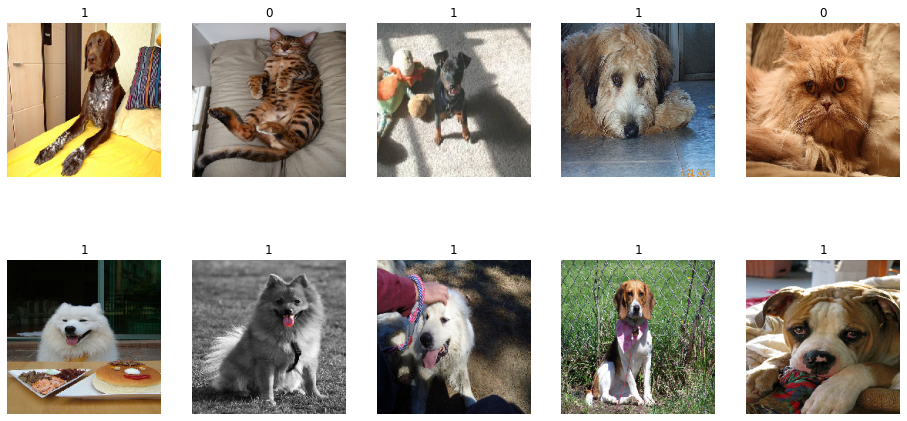

In [5]:

fig = plt.figure(figsize=(16,8))

for num in range(10):
    rng = random.randint(0,len(imagelist)-1) #Gera numeros aleatórios para selecionar os animais nas listas
    fig.add_subplot(2,5,num+1)
    plt.imshow(imagelist[rng])
    plt.title(labels[rng])
    plt.axis('off')
    

Percebe-se que a base está dividida corretamente, podendo então ser tratada para aplicação no modelo

### TRATAMENTO DA BASE

O primeiro passo é transformar a lista de arrays em um array de arrays e criar as bases x e y

In [8]:
X = np.asarray(arraylist)
y = np.asarray(labels)

In [7]:
print(X.shape)

(7390, 200, 200, 3)


In [8]:
print(X)

[[[[ 29.  37.  26.]
   [ 30.  38.  27.]
   [ 31.  39.  28.]
   ...
   [ 46.  54.  41.]
   [ 43.  51.  38.]
   [ 42.  50.  37.]]

  [[ 29.  37.  26.]
   [ 31.  39.  28.]
   [ 33.  41.  30.]
   ...
   [ 48.  56.  43.]
   [ 45.  53.  40.]
   [ 44.  52.  39.]]

  [[ 30.  38.  27.]
   [ 32.  40.  29.]
   [ 33.  41.  30.]
   ...
   [ 48.  56.  43.]
   [ 45.  53.  40.]
   [ 44.  52.  39.]]

  ...

  [[ 12.  19.  11.]
   [ 13.  20.  12.]
   [ 13.  20.  12.]
   ...
   [ 19.  27.  16.]
   [ 17.  25.  14.]
   [ 16.  24.  13.]]

  [[ 11.  18.  10.]
   [ 11.  18.  10.]
   [ 13.  20.  12.]
   ...
   [ 17.  25.  14.]
   [ 16.  24.  13.]
   [ 15.  23.  12.]]

  [[ 11.  18.  10.]
   [ 10.  17.   9.]
   [ 13.  20.  12.]
   ...
   [ 15.  23.  12.]
   [ 15.  23.  12.]
   [ 15.  23.  12.]]]


 [[[  7.  11.  10.]
   [  9.  11.  10.]
   [  9.   9.   9.]
   ...
   [ 39.  66.  96.]
   [ 36.  65.  95.]
   [ 39.  66.  95.]]

  [[  7.  11.  12.]
   [ 11.  12.  14.]
   [ 10.  12.  11.]
   ...
   [ 38.  67.  97.]
 

Em sequência, normaliza-se a base X dividindo seus termos por 255

In [9]:
X = X/255

In [10]:
print(X)

[[[[0.11372549 0.14509805 0.10196079]
   [0.11764706 0.14901961 0.10588235]
   [0.12156863 0.15294118 0.10980392]
   ...
   [0.18039216 0.21176471 0.16078432]
   [0.16862746 0.2        0.14901961]
   [0.16470589 0.19607843 0.14509805]]

  [[0.11372549 0.14509805 0.10196079]
   [0.12156863 0.15294118 0.10980392]
   [0.12941177 0.16078432 0.11764706]
   ...
   [0.1882353  0.21960784 0.16862746]
   [0.1764706  0.20784314 0.15686275]
   [0.17254902 0.20392157 0.15294118]]

  [[0.11764706 0.14901961 0.10588235]
   [0.1254902  0.15686275 0.11372549]
   [0.12941177 0.16078432 0.11764706]
   ...
   [0.1882353  0.21960784 0.16862746]
   [0.1764706  0.20784314 0.15686275]
   [0.17254902 0.20392157 0.15294118]]

  ...

  [[0.04705882 0.07450981 0.04313726]
   [0.05098039 0.07843138 0.04705882]
   [0.05098039 0.07843138 0.04705882]
   ...
   [0.07450981 0.10588235 0.0627451 ]
   [0.06666667 0.09803922 0.05490196]
   [0.0627451  0.09411765 0.05098039]]

  [[0.04313726 0.07058824 0.03921569]
   [0.0

Com a base normalizada, faz-se a divisão entre as bases de treino, teste e validação

In [10]:
X_res, X_test, y_res, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size= 0.25, random_state = 42, shuffle=True)

In [12]:
print(X_test.shape,y_test.shape)
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)

(1848, 200, 200, 3) (1848,)
(4156, 200, 200, 3) (4156,)
(1386, 200, 200, 3) (1386,)


### CONSTRUÇÃO DO MODELO

Com as bases prontas, segue-se à criação e treino do modelo. Será formada uma rede convolucional de 2 convoluções 3x3 com 20 filtros cada.

In [13]:
net = Sequential([
    Conv2D(20,3,activation='relu',input_shape=(200,200,3)),
    MaxPooling2D(),
    Dropout(0.5),
    Conv2D(20,3,activation='relu'),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(2),
    Activation('sigmoid')
])

net.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')

In [14]:
net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 20)      560       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 20)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 99, 99, 20)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 20)        3620      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 20)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 48, 48, 20)        0

In [15]:
net_results = net.fit(
            X_train,
            y_train,
            validation_data=(X_val,y_val),
            epochs = 20, 
            batch_size= 15,
            verbose = 1,
            callbacks = [es]
)

Epoch 1/20
278/278 [==============================] - 7s 9ms/step - loss: 0.6250 - accuracy: 0.6740 - val_loss: 0.5848 - val_accuracy: 0.6775
Epoch 2/20
278/278 [==============================] - 2s 7ms/step - loss: 0.5569 - accuracy: 0.7122 - val_loss: 0.5603 - val_accuracy: 0.6955
Epoch 3/20
278/278 [==============================] - 2s 7ms/step - loss: 0.5259 - accuracy: 0.7368 - val_loss: 0.5792 - val_accuracy: 0.6955
Epoch 4/20
278/278 [==============================] - 2s 7ms/step - loss: 0.4836 - accuracy: 0.7664 - val_loss: 0.5557 - val_accuracy: 0.6984
Epoch 5/20
278/278 [==============================] - 2s 7ms/step - loss: 0.4444 - accuracy: 0.7880 - val_loss: 0.5565 - val_accuracy: 0.7056
Epoch 6/20
278/278 [==============================] - 2s 7ms/step - loss: 0.4107 - accuracy: 0.8162 - val_loss: 0.5595 - val_accuracy: 0.7128
Epoch 7/20
278/278 [==============================] - 2s 7ms/step - loss: 0.3710 - accuracy: 0.8289 - val_loss: 0.5970 - val_accuracy: 0.6876
Epoch 

Percebe-se que o modelo sofreu overfitting, mesmo com o uso das camadas de dropout. Vejamos os resultados:

In [16]:
y_pred = net.predict(X_test)

accuracy_score(y_test, y_pred.argmax(1))

58/58 [==============================] - 0s 5ms/step


0.716991341991342

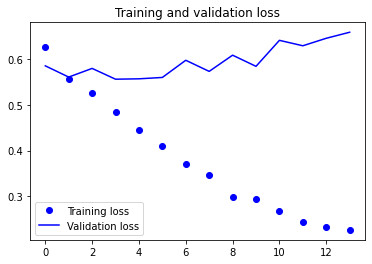

In [17]:
loss = net_results.history['loss']
val_loss = net_results.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Escala de Cinza

A base será então processada para tons de cinza, para verificar se há mudança nos resultados.

In [18]:
grayimages = [img.convert('L') for img in imagelist]

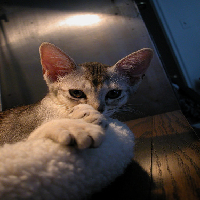

In [19]:
imagelist[1]

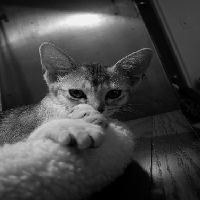

In [20]:
grayimages[1]

In [21]:
grayarrays = []
for img in grayimages:
    grayarrays.append(img_to_array(img))

In [22]:
X_gray = np.asarray(grayarrays)
y_gray = np.asarray(labels)
X_gray = X_gray/255

X_res_gray, X_test_gray, y_res_gray, y_test_gray = train_test_split(X_gray, y_gray, test_size = 0.25, random_state = 42, shuffle=True)

X_train_gray, X_val_gray, y_train_gray, y_val_gray = train_test_split(X_res_gray, y_res_gray, test_size= 0.25, random_state = 42, shuffle=True)

In [23]:
net_gray = Sequential([
    Conv2D(20,3,activation='relu',input_shape=(200,200,1)),
    MaxPooling2D(),
    Dropout(0.5),
    Conv2D(20,3,activation='relu'),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(2),
    Activation('sigmoid')
])

net_gray.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
net_gray_results = net_gray.fit(
            X_train_gray,
            y_train_gray,
            validation_data=(X_val_gray,y_val_gray),
            epochs = 20, 
            batch_size= 15,
            verbose = 1,
            callbacks = [es]
)

Epoch 1/20
278/278 [==============================] - 2s 8ms/step - loss: 0.6216 - accuracy: 0.6759 - val_loss: 0.6541 - val_accuracy: 0.6710
Epoch 2/20
278/278 [==============================] - 2s 7ms/step - loss: 0.5879 - accuracy: 0.6846 - val_loss: 0.5591 - val_accuracy: 0.7020
Epoch 3/20
278/278 [==============================] - 2s 7ms/step - loss: 0.5417 - accuracy: 0.7231 - val_loss: 0.5590 - val_accuracy: 0.6955
Epoch 4/20
278/278 [==============================] - 2s 7ms/step - loss: 0.4941 - accuracy: 0.7594 - val_loss: 0.5293 - val_accuracy: 0.7208
Epoch 5/20
278/278 [==============================] - 2s 7ms/step - loss: 0.4492 - accuracy: 0.7911 - val_loss: 0.5267 - val_accuracy: 0.7273
Epoch 6/20
278/278 [==============================] - 2s 7ms/step - loss: 0.4046 - accuracy: 0.8210 - val_loss: 0.5323 - val_accuracy: 0.7251
Epoch 7/20
278/278 [==============================] - 2s 7ms/step - loss: 0.3657 - accuracy: 0.8393 - val_loss: 0.5648 - val_accuracy: 0.7237
Epoch 

In [25]:
y_pred_gray = net_gray.predict(X_test_gray)

accuracy_score(y_test_gray, y_pred_gray.argmax(1))

58/58 [==============================] - 0s 3ms/step


0.7375541125541125

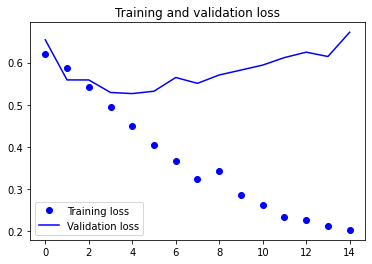

In [26]:
loss_gray = net_gray_results.history['loss']
val_loss_gray = net_gray_results.history['val_loss']
epochs = range(len(loss_gray))
plt.figure()
plt.plot(epochs, loss_gray, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_gray, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Percebe-se uma ligeira melhora no desempenho entre os resultados em escala de cinza e o padrão RGB

### Rede pré-treinada

Verifica-se então o resultado da rede em um arquitetura pré-treinada em Xception 'congelada', para fins de comparação:

In [11]:
base = tf.keras.applications.Xception(
    weights='imagenet',
    input_shape=(200,200,3),
    include_top=False
)
base.trainable = False

In [14]:
es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')

In [43]:
inputs = keras.Input(shape=(200, 200, 3))
x = base(inputs, training=False)
x = Flatten()(x)
outputs = keras.layers.Dense(2, activation='sigmoid')(x)
frozen_xce = keras.Model(inputs, outputs)

frozen_xce.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_6 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 2)                 200706    
                                                                 
Total params: 21,062,186
Trainable params: 200,706
Non-trainable params: 20,861,480
_________________________________________________________________


In [44]:
es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')
frozen_xce.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
frozen_results = frozen_xce.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=20,batch_size=15,callbacks=[es])

Epoch 1/20
278/278 [==============================] - 9s 26ms/step - loss: 0.3982 - accuracy: 0.9747 - val_loss: 0.4519 - val_accuracy: 0.9784
Epoch 2/20
278/278 [==============================] - 6s 23ms/step - loss: 0.1890 - accuracy: 0.9913 - val_loss: 0.3886 - val_accuracy: 0.9870
Epoch 3/20
278/278 [==============================] - 6s 23ms/step - loss: 0.0663 - accuracy: 0.9959 - val_loss: 0.6285 - val_accuracy: 0.9820
Epoch 4/20
278/278 [==============================] - 6s 23ms/step - loss: 0.0993 - accuracy: 0.9952 - val_loss: 1.1115 - val_accuracy: 0.9747
Epoch 5/20
278/278 [==============================] - 6s 23ms/step - loss: 0.0715 - accuracy: 0.9959 - val_loss: 0.5661 - val_accuracy: 0.9863
Epoch 6/20
278/278 [==============================] - 6s 23ms/step - loss: 0.0708 - accuracy: 0.9959 - val_loss: 0.4900 - val_accuracy: 0.9921
Epoch 7/20
278/278 [==============================] - 6s 23ms/step - loss: 0.0569 - accuracy: 0.9966 - val_loss: 0.7594 - val_accuracy: 0.9863

In [46]:
y_pred = frozen_xce.predict(X_test)

accuracy_score(y_test, y_pred.argmax(1))

58/58 [==============================] - 2s 30ms/step


0.9864718614718615

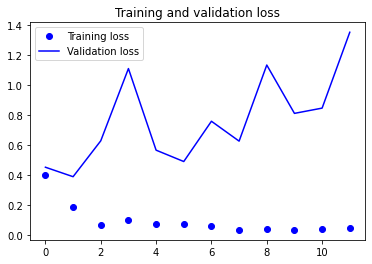

In [47]:
loss = frozen_results.history['loss']
val_loss = frozen_results.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Percebe-se que o modelo congelado apresenta resultados quase perfeitos de predição da base, o que pode indicar que as imagens do banco são próximas às imagens já treinadas da base 'imagenet'.

### Base parcialmente descongelada + camadas extras

A fim de comparação, testa-se novamente o modelo descongelando parcialmente e adicionando algumas camadas:

In [12]:
inputs = keras.Input(shape=(200, 200, 3))
x2 = base(inputs, training=False)
x2 = keras.layers.GlobalAveragePooling2D()(x2)
x2 = Dense(100, activation='relu')(x2)
x2 = Dropout(0.5)(x2)
x2 = Flatten()(x2)
outputs = keras.layers.Dense(2, activation='sigmoid')(x2)
semi_frozen = keras.Model(inputs, outputs)

semi_frozen.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                             

In [15]:
semi_frozen.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
semi_frozen_results = semi_frozen.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=20,batch_size=15,callbacks=[es])

Epoch 1/20
278/278 [==============================] - 11s 27ms/step - loss: 0.0678 - accuracy: 0.9764 - val_loss: 0.0404 - val_accuracy: 0.9892
Epoch 2/20
278/278 [==============================] - 7s 24ms/step - loss: 0.0273 - accuracy: 0.9892 - val_loss: 0.0388 - val_accuracy: 0.9913
Epoch 3/20
278/278 [==============================] - 7s 24ms/step - loss: 0.0236 - accuracy: 0.9937 - val_loss: 0.0484 - val_accuracy: 0.9885
Epoch 4/20
278/278 [==============================] - 7s 24ms/step - loss: 0.0112 - accuracy: 0.9969 - val_loss: 0.0384 - val_accuracy: 0.9928
Epoch 5/20
278/278 [==============================] - 7s 25ms/step - loss: 0.0145 - accuracy: 0.9959 - val_loss: 0.0488 - val_accuracy: 0.9913
Epoch 6/20
278/278 [==============================] - 7s 25ms/step - loss: 0.0091 - accuracy: 0.9976 - val_loss: 0.0477 - val_accuracy: 0.9921
Epoch 7/20
278/278 [==============================] - 7s 24ms/step - loss: 0.0096 - accuracy: 0.9964 - val_loss: 0.0526 - val_accuracy: 0.991

In [16]:
y_pred = semi_frozen.predict(X_test)

accuracy_score(y_test, y_pred.argmax(1))

58/58 [==============================] - 2s 31ms/step


0.9908008658008658

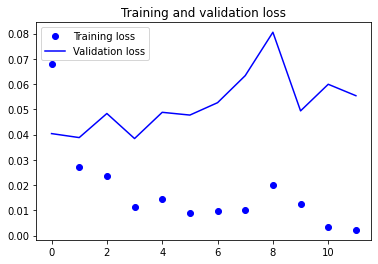

In [17]:
loss = semi_frozen_results.history['loss']
val_loss = semi_frozen_results.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Com a base parcialmente descongelada e com a adição de uma camada dense extra, um global pooling e um dropout, obtém-se um resultado ainda melhor reduzindo-se o overfitting

### Base descongelada + ajuste fino

Por fim, descongela-se toda a base e repete-se o treino sobre o modelo com camadas extras treinado anteriormente. O learning rate é reduzido e o callback também, para realizar o fine tuning.

In [18]:
base.trainable = True

semi_frozen.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                             

In [19]:
semi_frozen.compile(optimizer=keras.optimizers.Adam(1e-5), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

es2 = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 5, verbose = 1, mode = 'auto')

In [20]:
not_frozen_results = semi_frozen.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=15,batch_size=15,callbacks=[es2])

Epoch 1/15
278/278 [==============================] - 23s 71ms/step - loss: 0.0053 - accuracy: 0.9986 - val_loss: 0.0478 - val_accuracy: 0.9942
Epoch 2/15
278/278 [==============================] - 18s 66ms/step - loss: 0.0049 - accuracy: 0.9986 - val_loss: 0.0417 - val_accuracy: 0.9935
Epoch 3/15
278/278 [==============================] - 18s 65ms/step - loss: 0.0036 - accuracy: 0.9983 - val_loss: 0.0407 - val_accuracy: 0.9935
Epoch 4/15
278/278 [==============================] - 18s 66ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0520 - val_accuracy: 0.9928
Epoch 5/15
278/278 [==============================] - 18s 67ms/step - loss: 4.6681e-04 - accuracy: 1.0000 - val_loss: 0.0499 - val_accuracy: 0.9942
Epoch 6/15
278/278 [==============================] - 19s 67ms/step - loss: 4.3057e-05 - accuracy: 1.0000 - val_loss: 0.0514 - val_accuracy: 0.9942
Epoch 7/15
278/278 [==============================] - 18s 66ms/step - loss: 7.4076e-05 - accuracy: 1.0000 - val_loss: 0.0507 - v

In [21]:
y_pred = semi_frozen.predict(X_test)

accuracy_score(y_test, y_pred.argmax(1))

58/58 [==============================] - 2s 31ms/step


0.9951298701298701

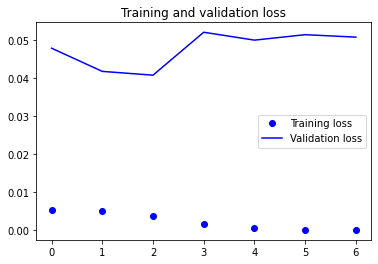

In [22]:
loss = not_frozen_results.history['loss']
val_loss = not_frozen_results.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Após o ajuste fino, ainda que nas épocas finais o modelo tenha sofrido overfitting por consequência do valor baixo de learning rate, este permitiu também obter o melhor desempenho possível no modelo, ainda superior ao modelo treinado anteriormente.

### RESULTADOS

Os resultados de accuracy obtidos sobre a base de teste podem ser visualizadas a seguir:

* Modelo Padrão:                                **0.717**
* Escala de cinza:                              **0.7375**
* Base Xception congelada:                      **0.9865**
* Base Xception congelada + camadas extras:     **0.9908**
* Base Xception não congelada + ajuste fino:    **0.9951**

# SOLUÇÃO 2 - RAÇAS DE ANIMAIS

Para a segunda solução, os animais serão classificados por raças, ao invés de apenas cães e gatos. Os passos da solução anterior serão reutilizados, mudando apenas o labeling

In [3]:
images = "D:/LETS CODE/Módulo 14/Redes Neurais/Projeto/Dataset Projeto/images/"     #path

imagelist=[]    #Lista para imagens
breedlist = []  #Lista de raças
arraylist=[]    #Lista de imagens como arrays
labels=[]       #Lista para os labels
label=0
for image in os.listdir(images):
    if ".jpg" in image:
        imagelist.append(load_img(images+image,target_size=(200,200)))      #importa as imagens em tamanho 200x200
        splitstring = image.split('.',1)[0].lower()     #Remove a extensão dos títulos
        cleanstring = re.sub(r'\d','',splitstring)      #Remove a numeração do título
        breed = cleanstring.replace('_',' ')        #Remove as '_'
        label = (label+1 if breed not in breedlist else label)
        labels.append(label)        #Verifica se a raça ja existe na lista de raças. Se ja existir, repete o label anterior, senão pula um numero.
        breedlist.append(breed)     #Insere a raça na lista de raças
        arraylist.append(img_to_array(load_img(images+image,target_size=(200,200))))        #importa as imagens em tamanho 200x200 e as converte para arrays

print(len(imagelist))
print(len(labels))
print(len(breedlist))

7390
7390
7390


### VISUALIZANDO OS DADOS

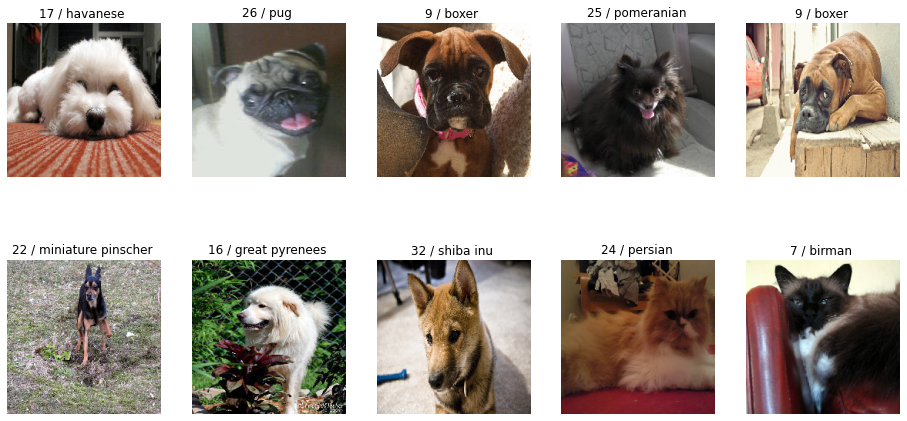

In [21]:
fig = plt.figure(figsize=(16,8))

for num in range(10):
    rng = random.randint(0,len(imagelist)-1)
    fig.add_subplot(2,5,num+1)
    plt.imshow(imagelist[rng])
    plt.title(str(labels[rng])+' / '+breedlist[rng])
    plt.axis('off')

Constata-se que o dataset foi corretamente rotulado. Segue-se ao tratamento da base.

### TRATAMENTO DA BASE

Primeiramente, transforma-se os valores de X em arrays. Devido à grande quantidade de classes, dessa vez é necessária também a aplicação do one hot encoder na variável Y

In [4]:
X = np.asarray(arraylist)
y = OneHotEncoder().fit_transform(np.asarray(labels).reshape(-1,1)).toarray()

In [5]:
X

array([[[[ 29.,  37.,  26.],
         [ 30.,  38.,  27.],
         [ 31.,  39.,  28.],
         ...,
         [ 46.,  54.,  41.],
         [ 43.,  51.,  38.],
         [ 42.,  50.,  37.]],

        [[ 29.,  37.,  26.],
         [ 31.,  39.,  28.],
         [ 33.,  41.,  30.],
         ...,
         [ 48.,  56.,  43.],
         [ 45.,  53.,  40.],
         [ 44.,  52.,  39.]],

        [[ 30.,  38.,  27.],
         [ 32.,  40.,  29.],
         [ 33.,  41.,  30.],
         ...,
         [ 48.,  56.,  43.],
         [ 45.,  53.,  40.],
         [ 44.,  52.,  39.]],

        ...,

        [[ 12.,  19.,  11.],
         [ 13.,  20.,  12.],
         [ 13.,  20.,  12.],
         ...,
         [ 19.,  27.,  16.],
         [ 17.,  25.,  14.],
         [ 16.,  24.,  13.]],

        [[ 11.,  18.,  10.],
         [ 11.,  18.,  10.],
         [ 13.,  20.,  12.],
         ...,
         [ 17.,  25.,  14.],
         [ 16.,  24.,  13.],
         [ 15.,  23.,  12.]],

        [[ 11.,  18.,  10.],
       

In [6]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

É normalizada também a variável X:

In [5]:
X=X/255

In [8]:
X

array([[[[0.11372549, 0.14509805, 0.10196079],
         [0.11764706, 0.14901961, 0.10588235],
         [0.12156863, 0.15294118, 0.10980392],
         ...,
         [0.18039216, 0.21176471, 0.16078432],
         [0.16862746, 0.2       , 0.14901961],
         [0.16470589, 0.19607843, 0.14509805]],

        [[0.11372549, 0.14509805, 0.10196079],
         [0.12156863, 0.15294118, 0.10980392],
         [0.12941177, 0.16078432, 0.11764706],
         ...,
         [0.1882353 , 0.21960784, 0.16862746],
         [0.1764706 , 0.20784314, 0.15686275],
         [0.17254902, 0.20392157, 0.15294118]],

        [[0.11764706, 0.14901961, 0.10588235],
         [0.1254902 , 0.15686275, 0.11372549],
         [0.12941177, 0.16078432, 0.11764706],
         ...,
         [0.1882353 , 0.21960784, 0.16862746],
         [0.1764706 , 0.20784314, 0.15686275],
         [0.17254902, 0.20392157, 0.15294118]],

        ...,

        [[0.04705882, 0.07450981, 0.04313726],
         [0.05098039, 0.07843138, 0.04705882]

Com a base normalizada, faz-se a divisão entre as bases de treino, teste e validação

In [6]:
X_res, X_test, y_res, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size= 0.25, random_state = 42, shuffle=True)

In [10]:
print(X_test.shape,y_test.shape)
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)

(1848, 200, 200, 3) (1848, 37)
(4156, 200, 200, 3) (4156, 37)
(1386, 200, 200, 3) (1386, 37)


Com as bases prontas, segue-se à criação e treino do modelo. Será formada uma rede convolucional de 2 convoluções 3x3 com 20 filtros cada.

In [11]:
net = Sequential([
    Conv2D(20,3,activation='relu',input_shape=(200,200,3)),
    MaxPooling2D(),
    Dropout(0.5),
    Conv2D(20,3,activation='relu'),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(37),
    Activation('softmax')
])

net.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')

In [12]:
net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 20)      560       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 20)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 99, 99, 20)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 20)        3620      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 20)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 48, 48, 20)        0

In [13]:
net_results = net.fit(
            X_train,
            y_train,
            validation_data=(X_val,y_val),
            epochs = 20, 
            batch_size= 10,
            verbose = 1,
            callbacks = [es]
)

Epoch 1/20
416/416 [==============================] - 7s 8ms/step - loss: 3.6614 - accuracy: 0.0450 - val_loss: 3.5844 - val_accuracy: 0.0563
Epoch 2/20
416/416 [==============================] - 3s 7ms/step - loss: 3.3653 - accuracy: 0.1023 - val_loss: 3.4873 - val_accuracy: 0.0743
Epoch 3/20
416/416 [==============================] - 3s 7ms/step - loss: 2.8463 - accuracy: 0.2334 - val_loss: 3.3831 - val_accuracy: 0.0952
Epoch 4/20
416/416 [==============================] - 3s 6ms/step - loss: 1.9719 - accuracy: 0.4637 - val_loss: 3.4648 - val_accuracy: 0.1162
Epoch 5/20
416/416 [==============================] - 3s 6ms/step - loss: 1.0489 - accuracy: 0.7072 - val_loss: 3.8198 - val_accuracy: 0.1190
Epoch 6/20
416/416 [==============================] - 3s 6ms/step - loss: 0.5180 - accuracy: 0.8479 - val_loss: 4.7480 - val_accuracy: 0.1270
Epoch 7/20
416/416 [==============================] - 3s 6ms/step - loss: 0.2951 - accuracy: 0.9165 - val_loss: 5.5346 - val_accuracy: 0.1154
Epoch 

Percebe-se que o modelo sofreu overfitting, mesmo com o uso das camadas de dropout. Vejamos os resultados:

In [15]:
y_pred = net.predict(X_test)

accuracy_score(y_test.argmax(1), y_pred.argmax(1))

58/58 [==============================] - 0s 4ms/step


0.10443722943722944

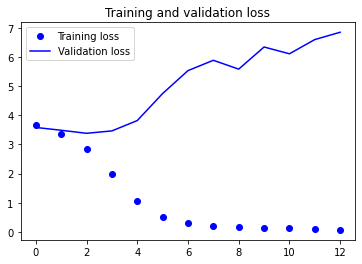

In [16]:
loss = net_results.history['loss']
val_loss = net_results.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Percebe-se um desempenho muito abaixo do visto anteriormente quando tentamos classificar as raças dos animais com a rede criada. Testa-se então o uso de uma rede pré-treinada

### REDE PRÉ-TREINADA

Verifica-se então o resultado da rede em um arquitetura pré-treinada novamente em Xception 'congelada', para fins de comparação:

In [7]:
base = tf.keras.applications.Xception(
    weights='imagenet',
    input_shape=(200,200,3),
    include_top=False
)
base.trainable = False

In [18]:
inputs = keras.Input(shape=(200, 200, 3))
x = base(inputs, training=False)
x = Flatten()(x)
outputs = keras.layers.Dense(37, activation='softmax')(x)
frozen_xce = keras.Model(inputs, outputs)

frozen_xce.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_1 (Dense)             (None, 37)                3713061   
                                                                 
Total params: 24,574,541
Trainable params: 3,713,061
Non-trainable params: 20,861,480
_________________________________________________________________


In [19]:
es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')
frozen_xce.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
frozen_results = frozen_xce.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=20,batch_size=15,callbacks=[es])

Epoch 1/20
278/278 [==============================] - 9s 27ms/step - loss: 5.4439 - accuracy: 0.7500 - val_loss: 7.2166 - val_accuracy: 0.7583
Epoch 2/20
278/278 [==============================] - 6s 23ms/step - loss: 2.1113 - accuracy: 0.8965 - val_loss: 6.2511 - val_accuracy: 0.8182
Epoch 3/20
278/278 [==============================] - 6s 23ms/step - loss: 0.9225 - accuracy: 0.9473 - val_loss: 5.7694 - val_accuracy: 0.8362
Epoch 4/20
278/278 [==============================] - 6s 23ms/step - loss: 0.9005 - accuracy: 0.9533 - val_loss: 7.0912 - val_accuracy: 0.8261
Epoch 5/20
278/278 [==============================] - 7s 23ms/step - loss: 0.7603 - accuracy: 0.9625 - val_loss: 7.7028 - val_accuracy: 0.8326
Epoch 6/20
278/278 [==============================] - 6s 23ms/step - loss: 0.5948 - accuracy: 0.9728 - val_loss: 7.9356 - val_accuracy: 0.8362
Epoch 7/20
278/278 [==============================] - 7s 24ms/step - loss: 0.7613 - accuracy: 0.9641 - val_loss: 8.5878 - val_accuracy: 0.8413

In [20]:
y_pred = frozen_xce.predict(X_test)

accuracy_score(y_test.argmax(1), y_pred.argmax(1))

58/58 [==============================] - 2s 32ms/step


0.8506493506493507

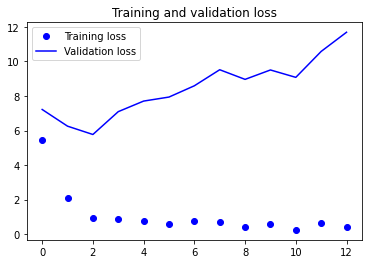

In [21]:
loss = frozen_results.history['loss']
val_loss = frozen_results.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Percebe-se que ainda que o modelo apresente novamente sinais de overfitting, o resultado nas bases de treino e validação são bem mais satisfatórios quando comparados com a rede construída anteriormente. Façamos os mesmos testes anteriores, descongelando parcialmente e totalmente a rede:

### Base parcialmente descongelada + camadas extras

A fim de comparação, testa-se novamente o modelo descongelando parcialmente e adicionando algumas camadas:

In [8]:
inputs = keras.Input(shape=(200, 200, 3))
x2 = base(inputs, training=False)
x2 = keras.layers.GlobalAveragePooling2D()(x2)
x2 = Dense(100, activation='relu')(x2)
x2 = Dropout(0.5)(x2)
x2 = Flatten()(x2)
outputs = keras.layers.Dense(37, activation='softmax')(x2)
semi_frozen = keras.Model(inputs, outputs)

semi_frozen.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                             

In [9]:
es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')
semi_frozen.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
semi_frozen_results = semi_frozen.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=20,batch_size=15,callbacks=[es])

Epoch 1/20
278/278 [==============================] - 11s 27ms/step - loss: 1.3298 - accuracy: 0.6449 - val_loss: 0.5207 - val_accuracy: 0.8413
Epoch 2/20
278/278 [==============================] - 6s 23ms/step - loss: 0.6029 - accuracy: 0.8162 - val_loss: 0.4269 - val_accuracy: 0.8672
Epoch 3/20
278/278 [==============================] - 6s 23ms/step - loss: 0.4875 - accuracy: 0.8477 - val_loss: 0.4648 - val_accuracy: 0.8442
Epoch 4/20
278/278 [==============================] - 6s 23ms/step - loss: 0.4012 - accuracy: 0.8722 - val_loss: 0.3927 - val_accuracy: 0.8817
Epoch 5/20
278/278 [==============================] - 7s 23ms/step - loss: 0.3467 - accuracy: 0.8840 - val_loss: 0.3917 - val_accuracy: 0.8759
Epoch 6/20
278/278 [==============================] - 7s 23ms/step - loss: 0.3238 - accuracy: 0.8898 - val_loss: 0.4246 - val_accuracy: 0.8651
Epoch 7/20
278/278 [==============================] - 6s 23ms/step - loss: 0.2894 - accuracy: 0.9040 - val_loss: 0.4144 - val_accuracy: 0.877

In [10]:
y_pred = semi_frozen.predict(X_test)

accuracy_score(y_test.argmax(1), y_pred.argmax(1))

58/58 [==============================] - 2s 31ms/step


0.8944805194805194

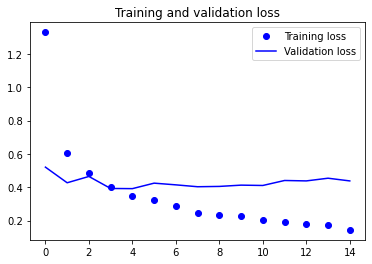

In [11]:
loss = semi_frozen_results.history['loss']
val_loss = semi_frozen_results.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Percebe-se um resultado ligeiramente superior ao caso anterior, ainda que o modelo siga com tendência ao overfitting. Façamos o teste descongelando a base totalmente e fazendo um ajuste fino.

In [12]:
base.trainable = True

semi_frozen.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                             

In [13]:
semi_frozen.compile(optimizer=keras.optimizers.Adam(1e-5), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es2 = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 7, verbose = 1, mode = 'auto')

In [14]:
not_frozen_results = semi_frozen.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=15,batch_size=15,callbacks=[es2])

Epoch 1/15
278/278 [==============================] - 22s 70ms/step - loss: 0.1344 - accuracy: 0.9524 - val_loss: 0.4649 - val_accuracy: 0.8810
Epoch 2/15
278/278 [==============================] - 18s 65ms/step - loss: 0.0955 - accuracy: 0.9654 - val_loss: 0.4770 - val_accuracy: 0.8838
Epoch 3/15
278/278 [==============================] - 18s 65ms/step - loss: 0.0681 - accuracy: 0.9752 - val_loss: 0.4577 - val_accuracy: 0.8911
Epoch 4/15
278/278 [==============================] - 18s 65ms/step - loss: 0.0630 - accuracy: 0.9783 - val_loss: 0.4791 - val_accuracy: 0.8939
Epoch 5/15
278/278 [==============================] - 18s 65ms/step - loss: 0.0455 - accuracy: 0.9848 - val_loss: 0.5103 - val_accuracy: 0.8954
Epoch 6/15
278/278 [==============================] - 18s 65ms/step - loss: 0.0393 - accuracy: 0.9868 - val_loss: 0.4767 - val_accuracy: 0.8983
Epoch 7/15
278/278 [==============================] - 18s 65ms/step - loss: 0.0350 - accuracy: 0.9909 - val_loss: 0.5329 - val_accuracy:

In [15]:
y_pred = semi_frozen.predict(X_test)

accuracy_score(y_test.argmax(1), y_pred.argmax(1))

58/58 [==============================] - 2s 31ms/step


0.9025974025974026

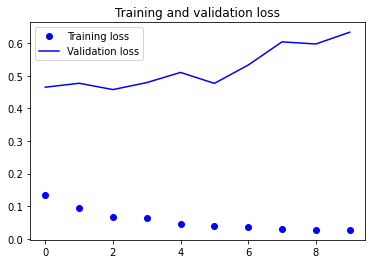

In [16]:
loss = not_frozen_results.history['loss']
val_loss = not_frozen_results.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Para a base totalmente descongelada, percebe-se um ganho muito pequeno de accuracy em relação às bases de treino e de teste, e o modelo apresenta claros sinais de overfitting, demonstrando que talvez esta não seja a melhor opção para este caso. Por fim, será feito oversampling na base para verificar qual o impacto nos resultados

### Oversampling

Serão realizadas três operações nas imagens: rotação vertical, rotação horizontal e ambas as rotações, cada operação em 500 imagens, o que totalizará aproximadamente 20% da base original.

In [4]:
for num in range(500):
    rng = random.randint(0,len(imagelist)-1)
    newimg = cv2.flip(arraylist[rng],1)
    arraylist.append(newimg)        #adiciona a imagem invertida horizontalmente à lista de arrays
    labels.append(labels[rng])        #copia a label da imagem original e adiciona à lista de labels

for num in range(500):
    rng = random.randint(0,len(imagelist)-1)
    newimg = cv2.flip(arraylist[rng],0)
    arraylist.append(newimg)        #adiciona a imagem invertida verticalmente à lista de arrays
    labels.append(labels[rng])        #copia a label da imagem original e adiciona à lista de labels

for num in range(500):
    rng = random.randint(0,len(imagelist)-1)
    newimg = cv2.flip(arraylist[rng],-1)
    arraylist.append(newimg)        #adiciona a imagem invertida verticalmente à lista de arrays
    labels.append(labels[rng])        #copia a label da imagem original e adiciona à lista de labels

print(len(imagelist))
print(len(arraylist))
print(len(labels))

7390
8890
8890


Com o oversampling realizado, será realizada a divisão dos dados e em seguida a execução do modelo. Será realizado o fit com a base parcialmente congelada treinada em imagenet com a adição de algumas camadas, para comparação com o resultado original.

In [5]:
X = np.asarray(arraylist)/255
y = OneHotEncoder().fit_transform(np.asarray(labels).reshape(-1,1)).toarray()

In [6]:
X_res, X_test, y_res, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size= 0.25, random_state = 42, shuffle=True)

In [7]:
print(X_test.shape,y_test.shape)
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)

(2223, 200, 200, 3) (2223, 37)
(5000, 200, 200, 3) (5000, 37)
(1667, 200, 200, 3) (1667, 37)


In [8]:
base = tf.keras.applications.Xception(
    weights='imagenet',
    input_shape=(200,200,3),
    include_top=False
)
base.trainable = False

In [9]:
inputs = keras.Input(shape=(200, 200, 3))
x2 = base(inputs, training=False)
x2 = keras.layers.GlobalAveragePooling2D()(x2)
x2 = Dense(100, activation='relu')(x2)
x2 = Dropout(0.5)(x2)
x2 = Flatten()(x2)
outputs = keras.layers.Dense(37, activation='softmax')(x2)
semi_frozen = keras.Model(inputs, outputs)

semi_frozen.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                             

In [10]:
es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')
semi_frozen.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
semi_frozen_results = semi_frozen.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=20,batch_size=15,callbacks=[es])

Epoch 1/20
334/334 [==============================] - 12s 27ms/step - loss: 1.4430 - accuracy: 0.6100 - val_loss: 0.5774 - val_accuracy: 0.8242
Epoch 2/20
334/334 [==============================] - 8s 23ms/step - loss: 0.7455 - accuracy: 0.7770 - val_loss: 0.5141 - val_accuracy: 0.8212
Epoch 3/20
334/334 [==============================] - 8s 24ms/step - loss: 0.5915 - accuracy: 0.8182 - val_loss: 0.4646 - val_accuracy: 0.8404
Epoch 4/20
334/334 [==============================] - 8s 25ms/step - loss: 0.4974 - accuracy: 0.8370 - val_loss: 0.4664 - val_accuracy: 0.8440
Epoch 5/20
334/334 [==============================] - 8s 25ms/step - loss: 0.4383 - accuracy: 0.8616 - val_loss: 0.4655 - val_accuracy: 0.8452
Epoch 6/20
334/334 [==============================] - 8s 24ms/step - loss: 0.4000 - accuracy: 0.8702 - val_loss: 0.4544 - val_accuracy: 0.8512
Epoch 7/20
334/334 [==============================] - 8s 23ms/step - loss: 0.3596 - accuracy: 0.8768 - val_loss: 0.4549 - val_accuracy: 0.846

In [11]:
y_pred = semi_frozen.predict(X_test)

accuracy_score(y_test.argmax(1), y_pred.argmax(1))

70/70 [==============================] - 3s 31ms/step


0.8618983355825461

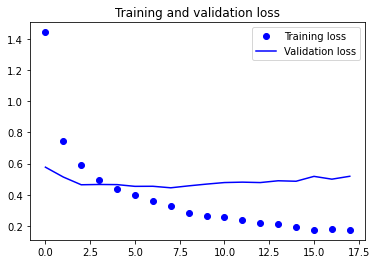

In [12]:
loss = semi_frozen_results.history['loss']
val_loss = semi_frozen_results.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Percebe-se que o modelo com oversampling teve desempenho inferior ao modelo original, de forma que talvez as técnicas para oversampling utilizadas não sejam as melhores.

### RESULTADOS

Os resultados obtidos pelos modelos podem ser visualizados abaixo:

* Modelo Padrão:                                    **0.1044**
* Base Xception congelada:                          **0.8506**
* Base Xception parc. cong. oversampling:           **0.8618**
* Base Xception parc. congelada:                    **0.8945**
* Base Xception não congelada:                      **0.9026**

### EXTRA - RAÇAS MELHORES CLASSIFICADAS

Utilizando o modelo de melhor desempenho (Xception não congelado), será feita a matriz de confusão para verificar em quais raças o modelo se sai melhor ou pior:

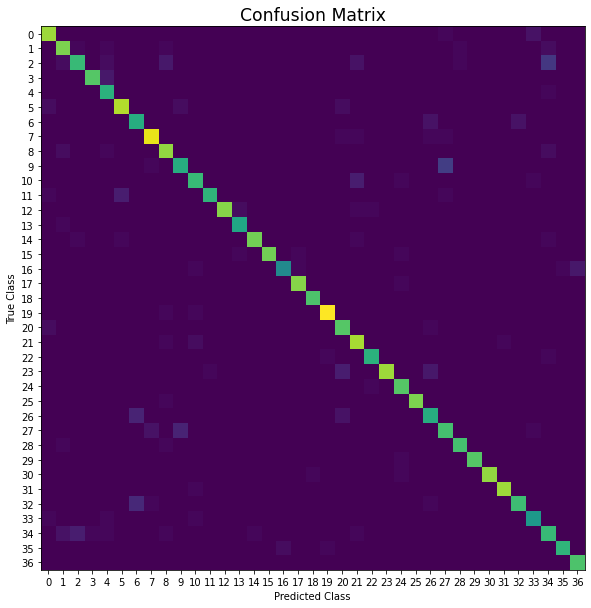

In [27]:
cm = confusion_matrix(y_test.argmax(1), y_pred.argmax(1))

# preparing for the plot
fig, ax = plt.subplots( figsize= (10, 10))

# displays data as an image
ax.imshow(cm)

# setup for labels, etc
ax.set_xticks(range(0, 37))
ax.set_yticks(range(0,37))

plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix', size='xx-large')
plt.show()

In [29]:
def get_breed(wantedlabel):         #Função derivada da função de importação das imagens, que descobre o titulo das imagens de acordo com o label
    list=[]
    label = 0
    for image in os.listdir(images):
        if ".jpg" in image:
            splitstring = image.split('.',1)[0].lower()     
            cleanstring = re.sub(r'\d','',splitstring)      
            breed = cleanstring.replace('_',' ')        
            label = (label+1 if breed not in list else label)
            list.append(breed)
            if label == wantedlabel:
                return breed

print(get_breed(16))
print(get_breed(33))

great pyrenees 
siamese 


De acordo com as cores da matriz de confusão, as raças com pior classificação foram as raças 16 e 33, que correspondem a Great Pyrenees (Cão dos Pirenéus) e Siamese (Gato Siamês), respectivamente. Uma possível alternativa para melhorar o desempenho com estas raças é encontrar bancos de dados com mais fotos destas raças para o treinamento, ou testar técnicas de oversampling focadas nas raças com pior índice de acerto.

# That's All Folks!